## Dotplot
Dotplot depicting selected genes differentially expressed in at least one cluster of MS cells compared to controls in CSF. Dot size encodes percentage of cells expressing the gene. Purple indicates higher, and turquoise indicates lower expression in MS, respectively.

In [1]:
#import libraries
import numpy as np
import matplotlib
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc #necessario importare scanpy in environment
#!conda install scvi -c bioconda -c conda-forge
save_path=""

# Importo funzioni

In [2]:
def DotPlotCompare(norm_X, genenames, genelist, clusterlabel, group, filt,dotsize=500,labelnames=None,
                   filename=None,
                  height=5,width=5):
    exprs = [norm_X[:,genenames==x] for x in genelist]
    exprs = np.asarray(exprs).squeeze()
    exprs = exprs / exprs.max(axis=1).reshape(len(genelist),1)
    exprs = pd.DataFrame(exprs.T, columns=genelist)
    exprs = exprs.loc[filt]
    clusterlabel = clusterlabel[filt]
    group = group[filt]
    mean_exprs = []
    clustercol = []
    groupcol = []
    colname = []
    if labelnames is None: 
        labelnames = np.unique(clusterlabel)
    for x in labelnames:
        for y in np.unique(group):
            if np.sum((clusterlabel==x)&(group==y))>0:
                avg=exprs.loc[(clusterlabel==x)&(group==y)].mean(axis=0)
                mean_exprs.append(np.log10(1+avg))
                colname.append(str(x)+'_'+str(y))
                clustercol.append(x)
                groupcol.append(y)
    mean_exprs = pd.concat(mean_exprs,axis=1)
    mean_exprs.columns = colname
    mean_exprs['genenames'] = mean_exprs.index
    temp = mean_exprs.melt(id_vars=['genenames'], value_vars=colname)
    temp['group'] = [x.split('_')[1] for x in temp['variable']]
    temp['cluster'] = [x.split('_')[0] for x in temp['variable']]
    groupname,temp['groupid'] = np.unique(temp['group'],return_inverse=True)
    genes = np.unique(temp['genenames'])
    temp['clusterid'] = [labelnames.index(x) for x in temp['cluster']]
    temp['geneid'] = [genelist.index(x) for x in temp['genenames']]
#     np.unique(temp['genenames'],return_inverse=True)
    plt.figure(figsize=(width*2,height))
    plt.subplot(1,2,1)
    plt.scatter(x=temp.loc[temp['groupid']==1]['geneid'],
                y=temp.loc[temp['groupid']==1]['clusterid'],
                s=temp.loc[temp['groupid']==1]['value']*dotsize*100,
                c='m',alpha=0.5,label='MS') # m means purple
    plt.scatter(x=temp.loc[temp['groupid']==0]['geneid'],
                y=temp.loc[temp['groupid']==0]['clusterid'],
                s=temp.loc[temp['groupid']==0]['value']*dotsize*100,
                c='c',alpha=0.5,label='Control') # c means light blue
    
    plt.xticks(ticks=np.arange(len(genes)), labels=genelist, rotation=90)
    plt.yticks(ticks=np.arange(len(labelnames)), labels=labelnames)
    plt.legend(bbox_to_anchor=(1, 0.5))
    
    plt.tight_layout()
    
    plt.subplot(1,2,2)
    for area in [0.01, 0.05, 0.1]:
        plt.scatter([], [], c='k', s=area*dotsize*100,
                    label=str(area))
        plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='log10 Expression')
    plt.axis('off')
    if filename is not None:
        plt.savefig(filename)
    else:
        plt.show()
    return temp

# Import all dataset
Link disponibile: https://figshare.com/articles/dataset/MS_CSF_h5ad/14356661

In [3]:
data = './MS_CSF.h5ad'
all_dataset = sc.read_h5ad(data)

# Load data

In [4]:

X = all_dataset.X.todense()

scaling_factor = X.mean(axis=1)
norm_X = X / scaling_factor.reshape(len(scaling_factor), 1)

In [5]:
# liste dei grafici dell'articolo
#bloodlist = ['PECAM1', 'ITGA5', 'IL17RA','ICOS','CLEC2D', 'LITAF','GRN', 'GZMA', 'KLRF1', 'IRF9', 'EOMES','STAT3', 'STAT4', 'MAF1','JUNB',  'NFATC1']
#csflist = ['IL12RB1', 'IL18RAP', 'TNFRSF18', 'HLA-C', 'CD5', 'CD74', 'ITGB1', 'STAT1', 'MUM1', 'IRF3','IRF7', 'IRF8', 'STAT5A','JUN', 'HIF1A']
gene_names_df = all_dataset.var
gene_names= gene_names_df.index.to_numpy()

# Nuova lista geni
Controllo se nuovo gene è presente nell'array di all_dataset.

In [6]:
df = all_dataset.var

res = df.loc[df.index == 'AFMID']
if len(res)!=0:
    print("Gene presente nel db di dati")
else: 
    print("Gene NON presente nel db di dati")
#df[df.index.str.contains("IL4")]

Gene presente nel db di dati


### Ricerca gene per parole chiave
Mostra tutti i geni che contengono stringa in input

In [7]:
df[df.index.str.contains("CD7")]

""
CD74
CD72
PDCD7
CD79B
CD7
CD70
CD79A


In [8]:
nuova_lista = ['IL12RB1','IL18RAP','TNFRSF18','HLA-C','CD5','CD74','ITGB1','STAT1','MUM1','IRF3','IRF7','IRF8','STAT5A','JUN','HIF1A']
#nuova_lista = ['KMO','AFMID','IDO1','CCBL2','KYNU','GOT2','AHR','STAT3','SOCS3']
#nuova_lista = ['KMO','AFMID','IDO1','CCBL2','KYNU','GOT2','AHR','STAT3','SOCS3','IL6ST','IL6R','IL4I1','IL2','IL4R','NR2F6']

# Importo variabili per plot

In [15]:
#importa altre variabili necessarie
#celllabels = np.load(save_path + 'meta/celllabels.npy',allow_pickle=True)
celllabels = np.asarray(all_dataset.obs.labels)
celltype, labels = np.unique(celllabels, return_inverse=True)

isCSF = np.asarray(all_dataset.obs['CSF'])
isMS = np.asarray(all_dataset.obs['MS'])
#isMS = np.load(save_path+'meta/isMS.npy',allow_pickle=True)
#isCSF = np.load(save_path+'meta/isCSF.npy',allow_pickle=True)
validclusters = np.asarray(all_dataset.obs['valid_clusters'])

#trasform in boolean
for i in range(len(validclusters)):
    if validclusters[i]=='True':
        validclusters[i]=True
    else: validclusters[i]=False
    
for i in range(len(isCSF)):
    if isCSF[i]=='True':
        isCSF[i]=True
    else: isCSF[i]=False
    
for i in range(len(isMS)):
    if isMS[i]=='True':
        isMS[i]=True
    else: isMS[i]=False
    
validclusters=np.array(validclusters, dtype=bool)
isCSF=np.array(isCSF, dtype=bool)
isMS=np.array(isMS, dtype=bool)

# Blood
Dotplot con nuovo array di geni per BLOOD. Labelnames contiene array di popolazioni cellulari 

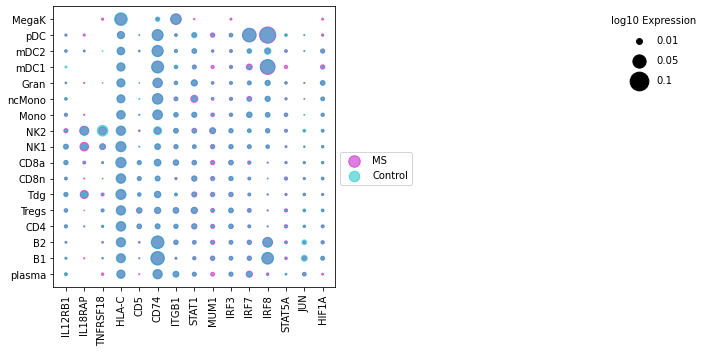

In [17]:
#isCSF==False : Blood 
file_plot='BloodANN.pdf' #path dove salvo immagine
scale=.5
temp = DotPlotCompare(norm_X, gene_names, 
            nuova_lista, celllabels, isMS,validclusters*(isCSF==False),
            labelnames=['plasma','B1','B2','CD4','Tregs','Tdg','CD8n','CD8a','NK1','NK2','Mono','ncMono','Gran','mDC1','mDC2','pDC','MegaK'],
            dotsize=140*scale**2,filename=save_path+file_plot,
            height=10*scale,width=10*scale)

# CSF 
Dotplot con nuovo array di geni per CSF

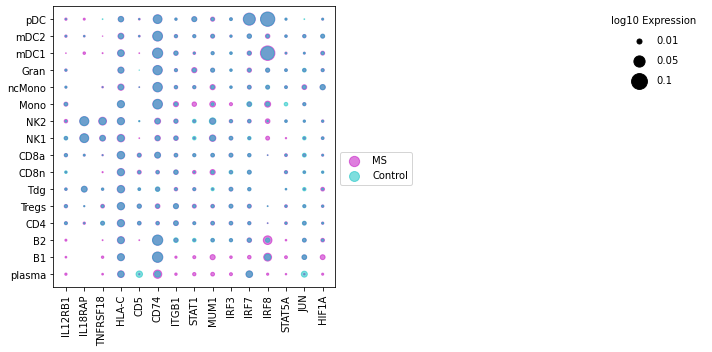

In [18]:
#isCSF==True : CSF
file_plot='CSFANN.pdf' #path dove salvo immagine
temp = DotPlotCompare(norm_X, gene_names, 
            nuova_lista, celllabels, isMS,validclusters*(isCSF==True),
            labelnames=['plasma','B1','B2','CD4','Tregs','Tdg','CD8n','CD8a','NK1','NK2','Mono','ncMono','Gran','mDC1','mDC2','pDC'],
            dotsize=100*scale**2,filename=save_path+file_plot,
            height=10*scale,width=10*scale)

In [64]:
"""
gene_names_df = all_dataset.var
genenames= gene_names_df.index.to_numpy()

genelist=  nuova_lista
filt = validclusters*(isCSF==False)
exprs = [norm_X[:,genenames==x] for x in genelist]
exprs = np.asarray(exprs).squeeze()
exprs = exprs / exprs.max(axis=1).reshape(len(genelist),1)
exprs = pd.DataFrame(exprs.T, columns=genelist)
exprs = exprs.loc[filt]
"""

'\ngene_names_df = all_dataset.var\ngenenames= gene_names_df.index.to_numpy()\n\ngenelist=  nuova_lista\nfilt = validclusters*(isCSF==False)\nexprs = [norm_X[:,genenames==x] for x in genelist]\nexprs = np.asarray(exprs).squeeze()\nexprs = exprs / exprs.max(axis=1).reshape(len(genelist),1)\nexprs = pd.DataFrame(exprs.T, columns=genelist)\nexprs = exprs.loc[filt]\n'